In [10]:
import hashlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

Попробуем применить CUPED на практике на синтетических данных (на реальных, конечно, эффект будет не таким большим).

В нём мы генерируем нашу метрику «трат» для 2-х групп пользователей так, что исходная привычка распределена логнормально, а в наших периодах до и во время эксперимента с некоторым нормальным отклонением от привычки каждого пользователя. При этом в тестовом периоде люди тратят больше.

In [2]:
users_num = 10000

df = pd.DataFrame()
df['user'] = range(users_num)
df['group'] = np.random.rand(users_num) < 0.5

df['user_mean'] = np.random.lognormal(mean=np.log(1000), sigma=0.5, size=users_num)
df['cost_before'] = np.abs(
    df['user_mean'] + np.random.normal(0, 100, size=users_num)
)
df['cost'] = np.abs(
    df['user_mean'] + np.random.normal(50, 100, size=users_num)
)

In [3]:
theta = np.cov(df['cost'], df['cost_before'])[0,1]/np.var(df['cost_before'])
theta

0.9739419276579006

In [5]:
df['cost_cuped'] = df['cost'] - theta * (df['cost_before'] - 
                                         np.mean(df['cost_before']))

In [6]:
np.var(df[df.group == 0].cost), np.var(df[df.group == 1].cost)

(377887.1927112566, 358130.7369912245)

In [7]:
np.var(df[df.group == 0].cost_cuped), np.var(df[df.group == 1].cost_cuped)

(19618.529198135737, 20159.90145180918)

Давайте практиковаться в бакетном тестировании, а заодно проверим, как будет различаться дисперсия CTR в бакете, если считать её двумя способами.

Сделайте переход к бакетам (возьмём 100 штук), с помощью md5 хэша с солью, применённой к айдишнику пользователя (от соли результат сильно различаться не будет, но можете взять 'my_salt').

Далее посчитайте два вида CTR: групповой (на основе количества кликов и просмотров в бакете) и обычный средний CTR пользователей в бакете (это нужно, чтобы мы сравнивали выборки одинаковых длин). Посчитайте среднеквадратичное отклонение этих CTR и сравните по одной из групп значения между этими способами.

In [8]:
np.random.seed(6)

users_num = 10000
mean_user_ctr = 0.2
beta = 20
alpha = mean_user_ctr * beta / (1 - mean_user_ctr)

df = pd.DataFrame()
df['user'] = range(users_num)
df['group'] = np.random.rand(users_num) < 0.5

df['base_user_ctr'] = np.random.beta(alpha, beta, size=users_num)
df['views'] = np.random.lognormal(mean=1, sigma=1, size=users_num).astype(int) + 1
df['clicks'] = np.random.binomial(df['views'], df['base_user_ctr'])

AttributeError: module 'matplotlib' has no attribute 'show'

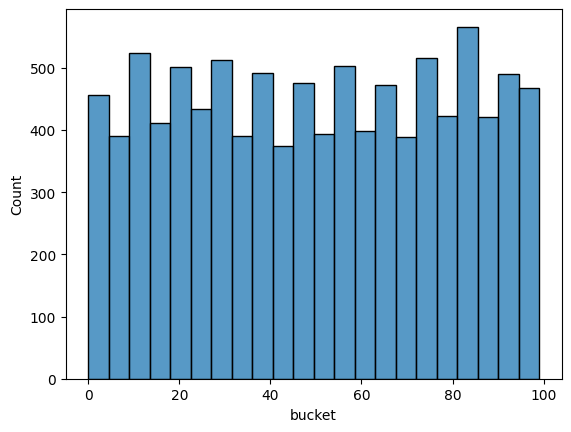

In [11]:
df['bucket'] = df['user'].apply(lambda x: int(hashlib.md5((str(x) + 'my_salt').encode()).hexdigest(),16)%100)

sns.histplot(df.bucket)
plt.show()

In [14]:
# Выбираем одну из групп для анализа
group_df = df[df['group'] == 0]

# Шаг 3: Рассчёт группового и среднего по пользователям CTR
buckets = group_df['bucket'].unique()
group_ctr = []
mean_user_ctr = []

for bucket in buckets:
    bucket_df = group_df[group_df['bucket'] == bucket]
    
    total_clicks = bucket_df['clicks'].sum()
    total_views = bucket_df['views'].sum()
    
    group_ctr.append(total_clicks / total_views)
    mean_user_ctr.append((bucket_df['clicks'] / bucket_df['views']).mean())

group_ctr = np.array(group_ctr)
mean_user_ctr = np.array(mean_user_ctr)

# Шаг 4: Сравнение среднеквадратичного отклонения
std_group_ctr = np.std(group_ctr)
std_mean_user_ctr = np.std(mean_user_ctr)

print("Среднеквадратическое отклонение группового CTR:", std_group_ctr)
print("Среднеквадратическое отклонение среднего по пользователям CTR:", std_mean_user_ctr)

Среднеквадратическое отклонение группового CTR: 0.027089697870797593
Среднеквадратическое отклонение среднего по пользователям CTR: 0.03398919968394813
